<a href="https://colab.research.google.com/github/AP-047/RClass-Classification-by-Rational-Approximation/blob/main/notebooks/1D_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GPU Set-up**

In [4]:
!nvcc --version

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

**Set Locale to UTF-8**

In [5]:
!apt-get install -y locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

**Upgrade setuptools and pip**

In [1]:
!pip install -U setuptools pip

**Install CuPy for CUDA 12.2**

In [2]:
!pip install cupy-cuda12x

**Sample code to check GPU usage**

In [3]:
import cupy as cp

# Check initial GPU memory usage
mempool = cp.get_default_memory_pool()
print("Initial GPU memory usage (bytes):", mempool.used_bytes())

# Create a large CuPy array on the GPU
size = 10**7  # Adjust size as needed to stress GPU
x = cp.random.random(size, dtype=cp.float32)

# Perform some GPU operations
y = x ** 9999999  # Square the elements
z = y.sum()  # Sum the elements

# Sync to ensure GPU computations are complete
cp.cuda.Device().synchronize()

# Check GPU memory usage after operations
print("Used GPU memory after computations (bytes):", mempool.used_bytes())

# Output the result of computation
print("Sum of squares:", z.get())  # Transfer result to CPU (NumPy)

Initial GPU memory usage (bytes): 0
Used GPU memory after computations (bytes): 120000512
Sum of squares: 2.320652647746195


**Test cuda**

In [6]:
import cupy as cp

# Check GPU memory usage
mempool = cp.get_default_memory_pool()
print("Used memory (bytes):", mempool.used_bytes())

Used memory (bytes): 120000512


**Check GPU memory usage dynamically**

In [7]:
import cupy as cp

# Allocate a large array
x = cp.random.random((10**8,), dtype=cp.float32)  # Large array to stress GPU

# Check GPU memory usage
mempool = cp.get_default_memory_pool()
print("Used GPU memory (bytes):", mempool.used_bytes())

# Perform computations
y = x ** 2
z = cp.sum(y)

# Sync and check memory usage again
cp.cuda.Device().synchronize()
print("Used GPU memory after computations (bytes):", mempool.used_bytes())

Used GPU memory (bytes): 520000512
Used GPU memory after computations (bytes): 880001024


**Ensure CuPy is using the CUDA backend**

In [8]:
# Check CUDA runtime version
print("CUDA runtime version:", cp.cuda.runtime.runtimeGetVersion())

CUDA runtime version: 12020


**Confirm GPU utilization**

In [9]:
# !LC_ALL=C.UTF-8 nvidia-smi

**Training**

Optimal Z (Maximum Deviation): 7.450580596923828e-07
Number of Iterations: 27
Z Values for All Iterations: [50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.1953125, 0.09765625, 0.048828125, 0.0244140625, 0.01220703125, 0.006103515625, 0.0030517578125, 0.00152587890625, 0.000762939453125, 0.0003814697265625, 0.00019073486328125, 9.5367431640625e-05, 4.76837158203125e-05, 2.384185791015625e-05, 1.1920928955078125e-05, 5.9604644775390625e-06, 2.9802322387695312e-06, 1.4901161193847656e-06, 7.450580596923828e-07]


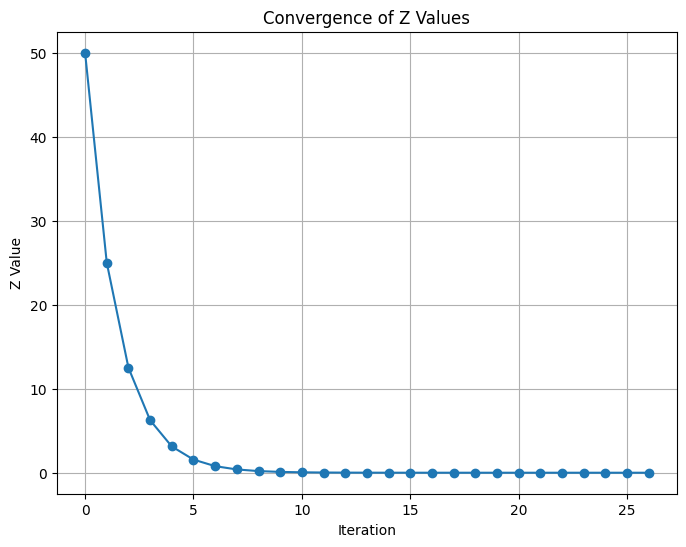

Optimized Coefficients (Numerator α): [7.50688014e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.29907202e-04 0.00000000e+00 2.13302485e-04 1.15565541e-03
 0.00000000e+00 0.00000000e+00 1.25109590e-01]
Optimized Coefficients (Denominator β): [1.55993069e-06 1.70773063e-05 1.20256098e-04 1.38102691e-05
 0.00000000e+00 0.00000000e+00 8.96326133e-03 9.53690201e-03
 0.00000000e+00 0.00000000e+00 1.66593423e-01]
Optimal θ: 7.900947235910656e-08


In [1]:
import cupy as cp
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Target function
def target_function(x):
    return cp.abs(x - 0.1)

# Rational function (coefficients to be optimized later)
def rational_function(x, alpha, beta):
    """
    r(x) = (α_0 + α_1*x + ...)/(β_0 + β_1*x + ...).
    """
    numerator = sum(alpha[i] * x**i for i in range(len(alpha)))
    denominator = sum(beta[i] * x**i for i in range(len(beta)))
    return numerator / denominator

# Feasibility check function
def check_feasibility_and_compute_coefficients(z, x_data, y_data, degree):
    num_data_points = len(x_data)
    num_coefficients = degree + 1  # Number of coefficients for num & den

    # Construct the G(x) and H(x) polynomials
    G = cp.array([[x**i for i in range(num_coefficients)] for x in x_data])  # Numerator polynomial
    H = cp.array([[x**i for i in range(num_coefficients)] for x in x_data])  # Denominator polynomial

    # Construct constraints for Ax <= b
    A = []
    b = []

    for i in range(num_data_points):
        f_plus_z = y_data[i] + z
        f_minus_z = y_data[i] - z

        # Constraint 1: (f(xi) - z) * β^T H(xi) - α^T G(xi) ≤ θ
        constraint_1 = cp.zeros(2 * num_coefficients + 1)
        constraint_1[:num_coefficients] = -G[i]  # Coefficients of α
        constraint_1[num_coefficients:2 * num_coefficients] = (f_minus_z) * H[i]  # Coefficients of β
        constraint_1[-1] = -1  # Coefficient of θ
        A.append(constraint_1)
        b.append(0)

        # Constraint 2: α^T G(xi) - (f(xi) - z) * β^T H(xi) ≤ θ
        constraint_2 = cp.zeros(2 * num_coefficients + 1)
        constraint_2[:num_coefficients] = G[i]  # Coefficients of α
        constraint_2[num_coefficients:2 * num_coefficients] = -(f_minus_z) * H[i]  # Coefficients of β
        constraint_2[-1] = -1  # Coefficient of θ
        A.append(constraint_2)
        b.append(0)

    # Positive constraints: β^T H(x) ≥ δ (small positive number)
    delta = 1e-6
    for i in range(num_data_points):
        constraint_pos = cp.zeros(2 * num_coefficients + 1)
        constraint_pos[num_coefficients:2 * num_coefficients] = -H[i]  # Coefficients of β
        A.append(constraint_pos)
        b.append(-delta)

    # Convert CuPy arrays to NumPy arrays for SciPy
    A = cp.asnumpy(cp.array(A))
    b = cp.asnumpy(cp.array(b))

    # Objective function to minimize θ
    c = cp.asnumpy(cp.zeros(2 * num_coefficients + 1))
    c[-1] = 1  # Only θ has a coefficient in the objective function

    # Solve the linear programming problem
    result = linprog(c, A_ub=A, b_ub=b, method="highs")

    # Check feasibility and return results
    if result.success:
        alpha_coefficients = result.x[:num_coefficients]
        beta_coefficients = result.x[num_coefficients:2 * num_coefficients]
        theta = result.x[-1]
        return True, alpha_coefficients, beta_coefficients, theta
    else:
        return False, None, None, None

# Bisection loop
def bisection_loop(x_data, y_data, degree, uL, uH, precision):
    optimal_alpha, optimal_beta, optimal_theta = None, None, None
    z_values = []

    while uH - uL > precision:
        z = (uL + uH) / 2
        z_values.append(z)
        feasible, alpha_coefficients, beta_coefficients, theta = check_feasibility_and_compute_coefficients(z, x_data, y_data, degree)

        if feasible:
            uH = z
            optimal_alpha, optimal_beta, optimal_theta = alpha_coefficients, beta_coefficients, theta
        else:
            uL = z

    return uH, optimal_alpha, optimal_beta, optimal_theta, z_values

# Main execution
if __name__ == "__main__":
    # Data setup
    degree = 10  # Polynomial degree
    x_data = cp.linspace(-0.5, 0.5, 50)  # Discretized data points
    y_data = target_function(x_data)  # Target values

    # Initial coefficients for the rational function (to be optimized)
    alpha_initial = [5, 3, 2]  # Coefficients of numerator
    beta_initial = [7, 4, 0]   # Coefficients of denominator

    # Bisection parameters
    uL = 0  # Initial lower bound
    uH = 100  # Initial upper bound
    precision = 1e-6  # Precision threshold

    # Run bisection loop
    optimal_z, optimal_alpha, optimal_beta, optimal_theta, z_values = bisection_loop(x_data, y_data, degree, uL, uH, precision)

    # Print results
    print(f"Optimal Z (Maximum Deviation): {optimal_z}")
    print(f"Number of Iterations: {len(z_values)}")
    print(f"Z Values for All Iterations: {z_values}")

    # Plot convergence of z values
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(z_values)), z_values, marker='o', linestyle='-')
    plt.xlabel("Iteration")
    plt.ylabel("Z Value")
    plt.title("Convergence of Z Values")
    plt.grid(True)
    plt.show()

    print(f"Optimized Coefficients (Numerator α): {optimal_alpha}")
    print(f"Optimized Coefficients (Denominator β): {optimal_beta}")
    print(f"Optimal θ: {optimal_theta}")



**Testing**

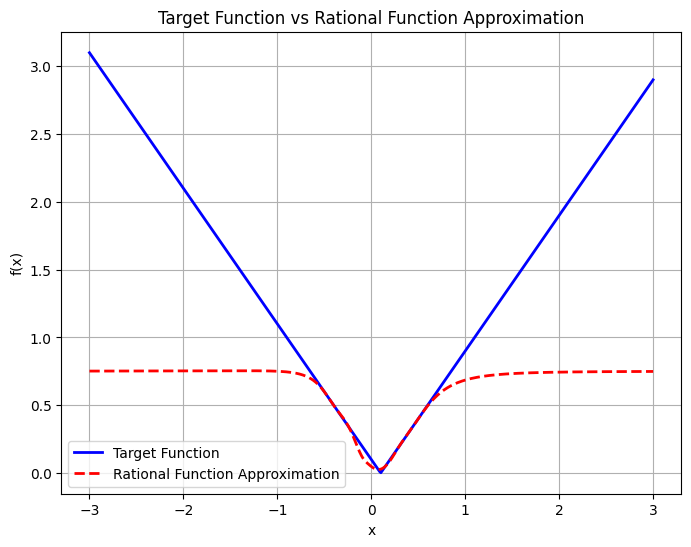

In [11]:
import matplotlib.pyplot as plt

def plot_functions(target_function, rational_function, alpha, beta, x_range):
    # Generate points for the plot
    x_test = cp.linspace(x_range[0], x_range[1], 500)  # Use CuPy for GPU computations
    y_target = target_function(x_test)  # Compute the target function values
    y_rational = cp.array([rational_function(x, alpha, beta) for x in x_test])  # Compute rational function values

    # Convert CuPy arrays to NumPy for plotting
    x_test = cp.asnumpy(x_test)
    y_target = cp.asnumpy(y_target)
    y_rational = cp.asnumpy(y_rational)

    # Plot the functions
    plt.figure(figsize=(8, 6))
    plt.plot(x_test, y_target, label="Target Function", color="blue", linewidth=2)
    plt.plot(x_test, y_rational, label="Rational Function Approximation", color="red", linestyle="--", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Target Function vs Rational Function Approximation")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution for plotting
if __name__ == "__main__":
    # Test points range for plotting
    x_range = [-3, 3]

    # Call the plotting function
    plot_functions(target_function, rational_function, optimal_alpha, optimal_beta, x_range)

new

In [12]:
def evaluate_rational_function(x, alpha, beta):
    """
    Evaluates the rational function at a given value of x.

    Parameters:
    - x: Input value.
    - alpha: Coefficients of the numerator.
    - beta: Coefficients of the denominator.

    Returns:
    - Rational function value at x.
    """
    # Compute numerator and denominator
    numerator = sum(alpha[i] * (x ** i) for i in range(len(alpha)))
    denominator = sum(beta[j] * (x ** j) for j in range(len(beta)))
    return numerator / denominator if denominator != 0 else float('inf')  # Avoid division by zero


def print_function_values(target_function, alpha, beta, x_values):
    """
    Prints the target and rational function values for a range of x values.

    Parameters:
    - target_function: Target function to compare.
    - alpha: Coefficients of the numerator.
    - beta: Coefficients of the denominator.
    - x_values: List or array of x values to evaluate.
    """
    print("x\tTarget\tRational")
    print("-" * 30)
    for x in x_values:
        target_value = target_function(x)
        rational_value = evaluate_rational_function(x, alpha, beta)
        print(f"{x:.2f}\t{target_value:.4f}\t{rational_value:.4f}")


# Example usage at the end of your main code:
if __name__ == "__main__":
    # Define a range of x values for testing
    x_test_values = cp.linspace(0.5, 6, 20)  # 10 points between -0.5 and 0.5

    # Print the target function and rational function outputs
    print_function_values(target_function, optimal_alpha, optimal_beta, x_test_values)


x	Target	Rational
------------------------------
0.50	0.4000	0.4002
0.79	0.6895	0.6198
1.08	0.9789	0.6995
1.37	1.2684	0.7271
1.66	1.5579	0.7383
1.95	1.8474	0.7435
2.24	2.1368	0.7463
2.53	2.4263	0.7478
2.82	2.7158	0.7488
3.11	3.0053	0.7494
3.39	3.2947	0.7498
3.68	3.5842	0.7501
3.97	3.8737	0.7503
4.26	4.1632	0.7504
4.55	4.4526	0.7505
4.84	4.7421	0.7506
5.13	5.0316	0.7507
5.42	5.3211	0.7507
5.71	5.6105	0.7508
6.00	5.9000	0.7508
